# Modelo para prever a irradiação solar em determinada localidade

Neste notebook, iremos desenvolver um projeto de análise/modelagem de dados com as seguintes etapas:
- **Importação das bibliotecas**: Carregamos as bibliotecas necessárias.
- **Carregamento e Exploração dos Dados**: Leitura dos dados e análise exploratória.
- **Pré-processamento**: Tratamento dos dados para deixá-los prontos para análise/modelagem.
- **Modelagem e Avaliação**: Construção e avaliação dos modelos.
- **Conclusão**: Interpretação dos resultados e próximos passos.


## 1. Instalação e Importação das Bibliotecas

Nesta etapa, importamos as bibliotecas necessárias para a análise


In [ ]:
!pip install pandas
!pip install unidecode
!pip install numpy
!pip install scikit-learn
!pip install xgboost
!pip install matplotlib
!pip install seaborn

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import unidecode

## 2. Carregamento dos Dados

Nesta seção, carregamos o dataset que será utilizado para a análise. Tratase de dados de irradiação solar, disponíveis no site do INMET. Utilizaremos dados de 2020 a 2024.

In [2]:
# Função para listar todos os arquivos CSV em um diretório
def list_csv_files(folder):
    csv_files = []
    for root, _, files in os.walk(folder):
        for file_name in files:
            if file_name.lower().endswith('.csv'):
                full_path = os.path.join(root, file_name)
                csv_files.append(full_path)
    return csv_files

path = "/home/lucas/Documents/dev_local/FIAP/FASE_3_1/estudo/files/"
csv_list = list_csv_files(path)

# Função para ler os metadados do CSV nas primeiras 8 linhas e seu conteúdo a partir da linha 9
def read_csv_metadata(file_path):

    
    with open(file_path, 'r', encoding='latin1') as f:
        meta_lines = [next(f).strip() for _ in range(8)]

    metadata = {}
    for line in meta_lines:
        parts = line.split(':', 1)
        if len(parts) == 2:
            key = parts[0].strip().upper().replace(" ", "_")
            value = parts[1].strip().lstrip(';').strip() 
            metadata[key] = value

    
    df = pd.read_csv(
        file_path,  # <-- Use o caminho do arquivo atual
        skiprows=8,
        encoding='latin1',
        sep=';',
    )

    
    for key, value in metadata.items():
        df[key] = value

    return df

# Função para combinar todos os arquivos CSV em um único DataFrame
def combine_csv_files(csv_list):
    all_dfs = []
    for file_path in csv_list:
        try:
            df = read_csv_metadata(file_path)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error in {file_path}: {e}")
    
    final_df = pd.concat(all_dfs, ignore_index=True)
    final_df.to_csv("combined_dataset.csv", index=False)
    return final_df


csv_list_initial = csv_list
final_df = combine_csv_files(csv_list_initial)

## 3. Análise Exploratória dos Dados

Aqui realizamos a análise inicial dos dados, verificando estatísticas descritivas, valores ausentes, distribuição de variáveis e outras informações relevantes para entender a estrutura do dataset.

In [ ]:
final_df.info()
final_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962960 entries, 0 to 4962959
Data columns (total 28 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   Data                                                   object 
 1   Hora UTC                                               object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       object 
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  object 
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        object 
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       object 
 6   RADIACAO GLOBAL (Kj/m²)                                object 
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           object 
 8   TEMPERATURA DO PONTO DE ORVALHO (°C)                   object 
 9   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             object 
 10  TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)             object 
 11

,UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))",Unnamed: 19
count,3.772338e+06,3.770545e+06,3.777831e+06,3.790182e+06,0.0
mean,7.424186e+01,6.865199e+01,7.152284e+01,1.557093e+02,NaN
std,2.033354e+01,2.158182e+01,2.101021e+01,9.916144e+01,NaN
min,4.000000e+00,7.000000e+00,7.000000e+00,1.000000e+00,NaN
25%,6.100000e+01,5.300000e+01,5.700000e+01,7.600000e+01,NaN
50%,7.900000e+01,7.200000e+01,7.600000e+01,1.340000e+02,NaN
75%,9.100000e+01,8.700000e+01,8.900000e+01,2.340000e+02,NaN
max,1.000000e+02,1.000000e+02,1.000000e+02,3.600000e+02,NaN


In [55]:
final_df.shape

(4962960, 28)

In [56]:
# analisando dados das coordenadas das estações
tmp = final_df
resultado = tmp[tmp['ESTACAO'].str.lower().isin(['brasilia', 'fortaleza'])].drop_duplicates('ESTACAO')[['ESTACAO', 'REGIAO', 'UF', 'LATITUDE', 'LONGITUDE']]
resultado


,ESTACAO,REGIAO,UF,LATITUDE,LONGITUDE
1704096,FORTALEZA,NE,CE,"-3,81583333","-38,53777777"
2485872,BRASILIA,CO,DF,"-15,78944444","-47,92583332"


<h3>Documentação de todas as colunas do dataset</h3>

| Nome da Coluna (normalizado) | Descrição | Unidade | Relevante |
|------------------------------|-----------|---------|-----------|
| regiao | Região | Texto | Não |
| uf' | Unidade Federativa | Texto | Não |
| estacao | Estação | Texto | Não |
| codigo_wmo | Código WMO | Texto | Não |
| latitude | Latitude | Graus decimais | Sim |
| longitude | Longitude | Graus decimais | Sim |
| altitude | Altitude | Metros | Não |
| data_de_fundacao | Data de fundação da estação | dd/mm/yyyy | Não |
| data | Data da medição | dd/mm/yyyy | Sim |
| hora_utc | Hora da medição em UTC | HH:MM | Sim | 
| precipitacao_total_horario_mm | Quantidade total de chuva no período de uma hora | Milímetros (mm) | Sim |
| pressao_atmosferica_ao_nivel_da_estacao_horaria_mb | Pressão atmosférica no nível da estação | Milibar (mB) | Não |
| pressao_atmosferica_max_na_hora_ant_aut_mb | Máxima pressão na hora anterior | Milibar (mB) | Não |
| pressao_atmosferica_min_na_hora_ant_aut_mb | Mínima pressão na hora anterior | Milibar (mB) | Não |
| radiacao_global_kj_m2 | Energia solar recebida no período | Kilojoules por metro² (kJ/m²) | Não |
| temperatura_do_ar_bulbo_seco_horaria_c | Temperatura do ar medida no bulbo seco | Graus Celsius (°C) | Sim |
| temperatura_do_ponto_de_orvalho_c | Temperatura na qual o ar atinge saturação | Graus Celsius (°C) | Não |
| temperatura_maxima_na_hora_ant_aut_c | Temperatura máxima registrada na hora anterior | Graus Celsius (°C) | Não |
| temperatura_minima_na_hora_ant_aut_c | Temperatura mínima registrada na hora anterior | Graus Celsius (°C) | Não |
| temperatura_orvalho_max_na_hora_ant_aut_c | Temperatura do ponto de orvalho máxima na hora anterior | Graus Celsius (°C) | Não |
| temperatura_orvalho_min_na_hora_ant_aut_c | Temperatura do ponto de orvalho mínima na hora anterior | Graus Celsius (°C) | Não |
| umidade_rel_max_na_hora_ant_aut | Umidade relativa máxima registrada na hora anterior | Porcentagem (%) | Não |
| umidade_rel_min_na_hora_ant_aut | Umidade relativa mínima registrada na hora anterior | Porcentagem (%) | Não |
| umidade_relativa_do_ar_horaria | Umidade relativa do ar medida na hora da medição | Porcentagem (%) | Sim |
| vento_direcao_horaria_gr | Direção do vento | Graus (0–360°) | Não |
| vento_rajada_maxima_m_s | Velocidade da rajada máxima de vento | Metros por segundo (m/s) | Não |
| vento_velocidade_horaria_m_s | Velocidade média do vento | Metros por segundo (m/s) | Sim |


## 4. Pré-processamento dos Dados

Nesta etapa, tratamos os dados para torná-los compatíveis com as análises futuras. Isso pode incluir:
- Tratamento de valores ausentes.
- Conversão de tipos de dados.
- Criação ou remoção de colunas.
- Normalização ou padronização das variáveis.


In [57]:
# Função para limpar e reordenar as colunas
def clean_and_reorder_columns(df):
    # Remover colunas com nome 'Unnamed'
    df = df.loc[:, ~df.columns.str.contains('^Unnamed', case=False)]

    # Mover as últimas 8 colunas (metadados) para o início
    meta_cols = df.columns[-8:].tolist()
    other_cols = df.columns[:-8].tolist()
    df = df[meta_cols + other_cols]

    # Normalizar os nomes das colunas
    df.columns = [
        unidecode.unidecode(col)  # remove acentos
        .strip()                  # remove espaços no início/fim
        .lower()                  # letras minúsculas
        .replace(" ", "_")        # espaços para underscore
        .replace(",", "")         # remove vírgulas
        .replace("(", "")         # remove parênteses
        .replace(")", "")         # remove parênteses
        .replace("/", "_")        # barra vira underscore
        .replace("°", "")         # remove grau
        .replace("²", "2")        # ajusta o quadrado paar 2
        .replace(".", "_")        # ponto vira underscore
        .replace("-", "_")        # hífen vira underscore
        .replace("%", "percent")  # % vira percent
        for col in df.columns
    ]

    return df

final_df = clean_and_reorder_columns(final_df)

# selecionando as colunas de interesse
target_columns_dataset = ['latitude','longitude','altitude','data','hora_utc','temperatura_do_ar___bulbo_seco_horaria_degc','precipitacao_total_horario_mm','umidade_relativa_do_ar_horaria_percent','vento_velocidade_horaria_m_s', 'radiacao_global_kj_m2']
df_target = final_df[target_columns_dataset]

In [61]:
# Analisando os dados e normalizando as colunas
# Campo latitude
if df_target['latitude'].dtype == 'object':
    df_target['latitude'] = (
        df_target['latitude']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo longitude
if df_target['longitude'].dtype == 'object':
    df_target['longitude'] = (
        df_target['longitude']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo altitude
if df_target['altitude'].dtype == 'object':
    df_target['altitude'] = (
        df_target['altitude']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo data
if df_target['data'].dtype == 'object':
    df_target['data'] = pd.to_datetime(df_target['data'], 
                                       format='%Y/%m/%d')

# Campo hora_utc
if df_target['hora_utc'].dtype == 'object':
    df_target['hora_utc'] = pd.to_datetime(df_target['hora_utc'].str.replace(' UTC', ''), 
                                           format='%H%M').dt.time

# Campo temperatura_do_ar___bulbo_seco_horaria_degc 
if df_target['temperatura_do_ar___bulbo_seco_horaria_degc'].dtype == 'object':
    df_target['temperatura_do_ar___bulbo_seco_horaria_degc'] = (
        df_target['temperatura_do_ar___bulbo_seco_horaria_degc']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo precipitacao_total_horario_mm
if df_target['precipitacao_total_horario_mm'].dtype == 'object':
    df_target['precipitacao_total_horario_mm'] = (
        df_target['precipitacao_total_horario_mm']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo umidade_relativa_do_ar_horaria_percent
if df_target['umidade_relativa_do_ar_horaria_percent'].dtype == 'object':
    df_target['umidade_relativa_do_ar_horaria_percent'] = (
        df_target['umidade_relativa_do_ar_horaria_percent']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# Campo vento_velocidade_horaria_m_s
if df_target['vento_velocidade_horaria_m_s'].dtype == 'object':
    df_target['vento_velocidade_horaria_m_s'] = (
        df_target['vento_velocidade_horaria_m_s']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )

# campo radiacao_global_kj_m2
if df_target['radiacao_global_kj_m2'].dtype == 'object':
    df_target['radiacao_global_kj_m2'] = (
        df_target['radiacao_global_kj_m2']
        .str.replace(',', '.', regex=False)  # troca vírgula por ponto
        .astype(float)                       # converte para float
    )
    df_target['radiacao_global_kj_m2'] = df_target['radiacao_global_kj_m2'].fillna(0)


# Removendo os valores com outliers

# Ajuste do campo temperatura_do_ar___bulbo_seco_horaria_degc para deletar valores fora de -15 e 45
df_target = df_target[df_target['temperatura_do_ar___bulbo_seco_horaria_degc'] >= -15]
df_target = df_target[df_target['temperatura_do_ar___bulbo_seco_horaria_degc'] <= 45]

/tmp/ipykernel_27327/3104341281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['latitude'] = (
/tmp/ipykernel_27327/3104341281.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['longitude'] = (
/tmp/ipykernel_27327/3104341281.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [62]:
# analisando dados das coordenadas das estações
tmp = df_target
for col in ['latitude', 'longitude', 'altitude', 'dist_equador']:
    if col in tmp.columns:
        print(f"{col}: min={tmp[col].min()}, max={tmp[col].max()}, unique values={tmp[col].nunique()}")


latitude: min=-33.74222221, max=3.81361111, unique values=539
longitude: min=-72.6811111, max=-34.81555555, unique values=538
altitude: min=2.0, max=1790.38, unique values=529


In [63]:
df_target.shape

(4031319, 10)

In [64]:
df_target.columns


Index(['latitude', 'longitude', 'altitude', 'data', 'hora_utc',
       'temperatura_do_ar___bulbo_seco_horaria_degc',
       'precipitacao_total_horario_mm',
       'umidade_relativa_do_ar_horaria_percent',
       'vento_velocidade_horaria_m_s', 'radiacao_global_kj_m2'],
      dtype='object')

## 5. Preparação de dados

In [65]:
# Adicionar as variáveis cíclicas para hora que estavam faltando
df_prep = df_target.copy()

# Extrair hora de hora_utc
df_prep['hora'] = df_prep['hora_utc'].astype(str).str.split(':').str[0].astype(int)
# Criar as variáveis cíclicas para hora
df_prep['hora_sen'] = np.sin(2 * np.pi * df_prep['hora'] / 24)
df_prep['hora_cos'] = np.cos(2 * np.pi * df_prep['hora'] / 24)

# Extrair componentes temporais
df_prep['ano'] = df_prep['data'].dt.year
df_prep['mes'] = df_prep['data'].dt.month
df_prep['dia'] = df_prep['data'].dt.day
df_prep['dia_ano'] = df_prep['data'].dt.dayofyear

# Criar variáveis cíclicas para o mês e dia do ano
df_prep['mes_sen'] = np.sin(2 * np.pi * df_prep['mes'] / 12)
df_prep['mes_cos'] = np.cos(2 * np.pi * df_prep['mes'] / 12)
df_prep['dia_ano_sen'] = np.sin(2 * np.pi * df_prep['dia_ano'] / 365)
df_prep['dia_ano_cos'] = np.cos(2 * np.pi * df_prep['dia_ano'] / 365)

# Verificar as colunas finais
df_prep.columns.tolist()

['latitude',
 'longitude',
 'altitude',
 'data',
 'hora_utc',
 'temperatura_do_ar___bulbo_seco_horaria_degc',
 'precipitacao_total_horario_mm',
 'umidade_relativa_do_ar_horaria_percent',
 'vento_velocidade_horaria_m_s',
 'radiacao_global_kj_m2',
 'hora',
 'hora_sen',
 'hora_cos',
 'ano',
 'mes',
 'dia',
 'dia_ano',
 'mes_sen',
 'mes_cos',
 'dia_ano_sen',
 'dia_ano_cos']

In [67]:
tmp = df_prep
for col in ['latitude', 'longitude', 'altitude', 'dist_equador']:
    if col in tmp.columns:
        print(f"{col}: min={tmp[col].min()}, max={tmp[col].max()}, unique values={tmp[col].nunique()}")

latitude: min=-33.74222221, max=3.81361111, unique values=539
longitude: min=-72.6811111, max=-34.81555555, unique values=538
altitude: min=2.0, max=1790.38, unique values=529


## 6. Modelagem

Neste projeto, estamos desenvolvendo um modelo de machine learning para prever a radiação solar global (em kJ/m²) com base em dados meteorológicos e geográficos do Brasil. Este é um problema de regressão onde queremos estimar a quantidade de radiação solar que atinge uma determinada localização.

O modelo utilizará variáveis como:
- Coordenadas geográficas (latitude, longitude, altitude)
- Variáveis temporais cíclicas (hora do dia, mês, dia do ano)
- Condições meteorológicas (temperatura, precipitação, umidade, velocidade do vento)
 
Também criamos features derivadas como distância do equador e interações entre latitude e mês para capturar  a variação sazonal da radiação solar em diferentes latitudes. Este modelo poderá ser usado para estimar o potencial de geração de energia solar em diferentes regiões do Brasil.



In [68]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Definir as features iniciais
features = [
    'latitude', 'longitude', 'altitude',
    'mes', 'dia_ano', 'hora',
    'mes_sen', 'mes_cos', 
    'hora_sen', 'hora_cos',
    'dia_ano_sen', 'dia_ano_cos',
    'temperatura_do_ar___bulbo_seco_horaria_degc',
    'precipitacao_total_horario_mm',
    'umidade_relativa_do_ar_horaria_percent',
    'vento_velocidade_horaria_m_s'
]

# Filtrar para usar apenas as features que existem no DataFrame
features_existentes = [f for f in features if f in df_prep.columns]
print("Features iniciais que serão usadas no modelo:", features_existentes)

# Separar features (X) e target (y)
X = df_prep[features_existentes]
y = df_prep['radiacao_global_kj_m2']

# Remover outliers geográficos
mask_geo = (X['latitude'] >= -33.5) & (X['latitude'] <= 5.5) & \
         (X['longitude'] >= -74.0) & (X['longitude'] <= -34.0)

X_filtered = X[mask_geo]
y_filtered = y[mask_geo]

print(f"Removidos {len(X) - len(X_filtered)} registros com coordenadas fora dos limites do Brasil")

# Usar os dados filtrados para continuar
X = X_filtered
y = y_filtered

# Adicionar features geográficas derivadas - MANTENDO ESCALA ORIGINAL
# Distância do equador (valor absoluto da latitude)
X['dist_equador'] = np.abs(X['latitude'])

# Interação latitude-mês (captura variação sazonal por latitude)
X['lat_mes_interact'] = X['latitude'] * np.cos(2 * np.pi * X['mes'] / 12)

# Ângulo de elevação solar aproximado
X['declinacao_solar'] = 23.45 * np.sin(2 * np.pi * (X['dia_ano'] - 81) / 365)
X['elevacao_solar_approx'] = 90 - np.abs(X['latitude'] - X['declinacao_solar'])

# Adicionar interação de latitude com hora do dia
X['lat_hora_interact'] = X['latitude'] * np.sin(2 * np.pi * (X['hora'] - 12) / 24)

# Verificar valores nulos nas features
nulos_x = X.isnull().sum()
nulos_y = y.isnull().sum()

print(f"Valores nulos nas features:")
for col, count in nulos_x[nulos_x > 0].items():
    print(f"  {col}: {count} ({count/len(X)*100:.2f}%)")

print(f"Valores nulos no target: {nulos_y} ({nulos_y/len(y)*100:.2f}%)")

# Preencher valores nulos nas features (se houver)
if nulos_x.sum() > 0:
    print("Preenchendo valores nulos nas features com médias")
    X = X.fillna(X.mean())

# Apenas normalizar features meteorológicas, NÃO normalizar coordenadas geográficas
features_to_scale = [
    'temperatura_do_ar___bulbo_seco_horaria_degc',
    'precipitacao_total_horario_mm',
    'umidade_relativa_do_ar_horaria_percent',
    'vento_velocidade_horaria_m_s'
]

# Filtrar apenas features que existem
features_to_scale = [f for f in features_to_scale if f in X.columns]

# Criar e aplicar o StandardScaler apenas para features meteorológicas
scaler = StandardScaler()
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

# Verificar a variabilidade das coordenadas geográficas
for col in ['latitude', 'longitude', 'altitude', 'dist_equador']:
    if col in X.columns:
        print(f"{col}: min={X[col].min()}, max={X[col].max()}, unique values={X[col].nunique()}")

# Verificar correlações após as modificações
X_temp = X.copy()
X_temp['radiacao_solar'] = y
corr_with_target = X_temp.corr()['radiacao_solar'].sort_values(ascending=False)
print("\nCorrelações após modificação:")
print(corr_with_target)

# Dividir em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Features finais utilizadas: {X.columns.tolist()}")
print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Features iniciais que serão usadas no modelo: ['latitude', 'longitude', 'altitude', 'mes', 'dia_ano', 'hora', 'mes_sen', 'mes_cos', 'hora_sen', 'hora_cos', 'dia_ano_sen', 'dia_ano_cos', 'temperatura_do_ar___bulbo_seco_horaria_degc', 'precipitacao_total_horario_mm', 'umidade_relativa_do_ar_horaria_percent', 'vento_velocidade_horaria_m_s']
Removidos 8613 registros com coordenadas fora dos limites do Brasil
Valores nulos nas features:
  precipitacao_total_horario_mm: 417518 (10.38%)
  umidade_relativa_do_ar_horaria_percent: 281479 (7.00%)
  vento_velocidade_horaria_m_s: 285650 (7.10%)
Valores nulos no target: 0 (0.00%)
Preenchendo valores nulos nas features com médias
latitude: min=-32.53472221, max=3.81361111, unique values=538
longitude: min=-72.6811111, max=-34.81555555, unique values=537
altitude: min=2.0, max=1790.38, unique values=528
dist_equador: min=0.03499999, max=32.53472221, unique values=538

Correlações após modificação:
radiacao_solar                                 1.00000

In [69]:
# Verificar correlações após as modificações
X_temp = X.copy()
X_temp['radiacao_solar'] = y

# Calcular correlações
corr_with_target = X_temp.corr()['radiacao_solar'].sort_values(ascending=False)

print("\nCorrelações após modificação:")
print(corr_with_target)


Correlações após modificação:
radiacao_solar                                 1.000000
temperatura_do_ar___bulbo_seco_horaria_degc    0.540406
hora                                           0.399415
vento_velocidade_horaria_m_s                   0.291024
elevacao_solar_approx                          0.093240
mes_cos                                        0.074134
dia_ano_cos                                    0.073515
longitude                                      0.031868
latitude                                       0.031631
altitude                                       0.010750
dia_ano                                        0.007637
mes                                            0.007396
mes_sen                                       -0.001054
dia_ano_sen                                   -0.019521
dist_equador                                  -0.031930
precipitacao_total_horario_mm                 -0.058693
declinacao_solar                              -0.075917
lat_mes_interact 

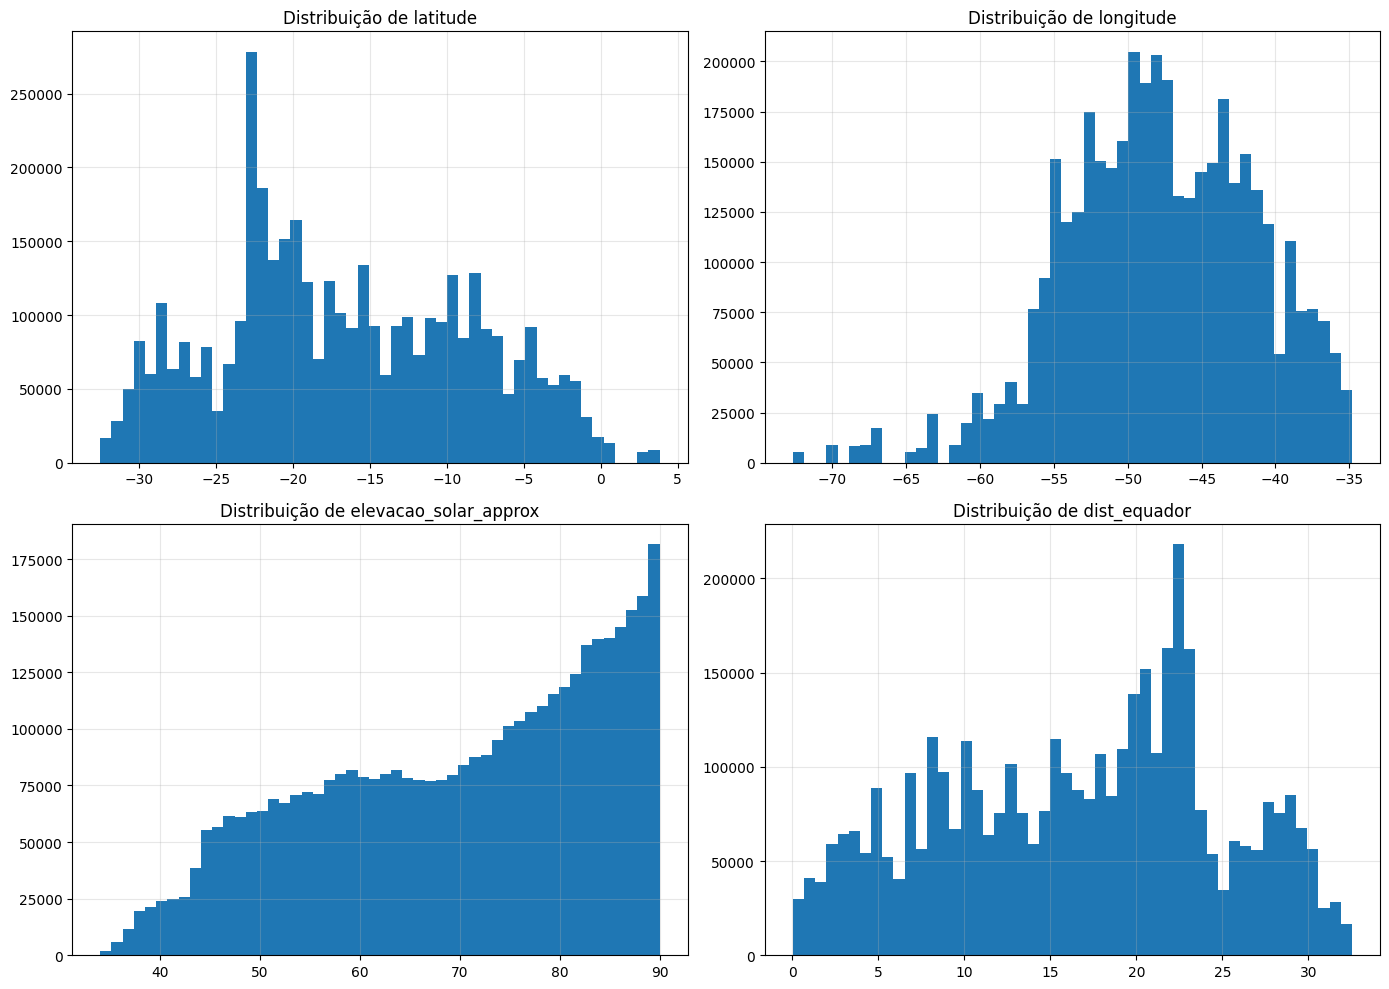

In [72]:
# Verificar a distribuição de algumas features principais
import matplotlib.pyplot as plt

features_para_verificar = ['latitude', 'longitude', 'elevacao_solar_approx', 'dist_equador']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_para_verificar):
    axes[i].hist(X[feature], bins=50)
    axes[i].set_title(f'Distribuição de {feature}')
    axes[i].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

## 7 Treinar o modelo XGBoost

In [75]:
modelo = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Verificar quais parâmetros são aceitos para este modelo
from inspect import signature
sig = signature(modelo.fit)
params = sig.parameters
print("Parâmetros aceitos para fit():", list(params.keys()))

# Treinamento compatível com diferentes versões
try:
    # Tentativa com a API mais recente
    modelo.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',            # métrica de avaliação
        early_stopping_rounds=10,      # parar treinamento se não houver melhoria
        verbose=True                   # mostrar progresso
    )
except TypeError:
    # Versão alternativa sem eval_metric
    try:
        modelo.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=10,  # parar treinamento se não houver melhoria
            verbose=True               # mostrar progresso
        )
    except TypeError:
        # Versão mais simples se tudo falhar
        print("Usando versão simplificada do treinamento")
        modelo.fit(X_train, y_train)

print("Modelo treinado com sucesso!")

Parâmetros aceitos para fit(): ['X', 'y', 'sample_weight', 'base_margin', 'eval_set', 'verbose', 'xgb_model', 'sample_weight_eval_set', 'base_margin_eval_set', 'feature_weights']
Usando versão simplificada do treinamento
Modelo treinado com sucesso!


## 8. Avaliação do Modelo de Previsão de Radiação Solar

Após o treinamento do modelo XGBoost, realizamos a avaliação do seu desempenho utilizando o conjunto de teste. Os resultados obtidos foram:

### Resultados da avaliação:
- **RMSE (Root Mean Square Error)**: 266.52 kJ/m² - Representa o erro quadrático médio entre as previsões e os valores reais
- **MAE (Mean Absolute Error)**: 130.27 kJ/m² - Representa o erro absoluto médio das previsões
- **R² (Coeficiente de Determinação)**: 0.9365 - Indica que o modelo explica aproximadamente 93.65% da variabilidade dos dados

Estes resultados demonstram um bom desempenho do modelo na previsão da radiação solar, com um alto coeficiente de determinação e erros aceitáveis considerando a escala dos dados.


In [76]:
# Fazer previsões nos dados de teste
y_pred = modelo.predict(X_test)

# Calcular métricas de avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Resultados da avaliação:")
print(f"RMSE: {rmse:.2f} kJ/m²")
print(f"MAE: {mae:.2f} kJ/m²")
print(f"R²: {r2:.4f}")

Resultados da avaliação:
RMSE: 266.52 kJ/m²
MAE: 130.27 kJ/m²
R²: 0.9365


<Figure size 1200x800 with 0 Axes>

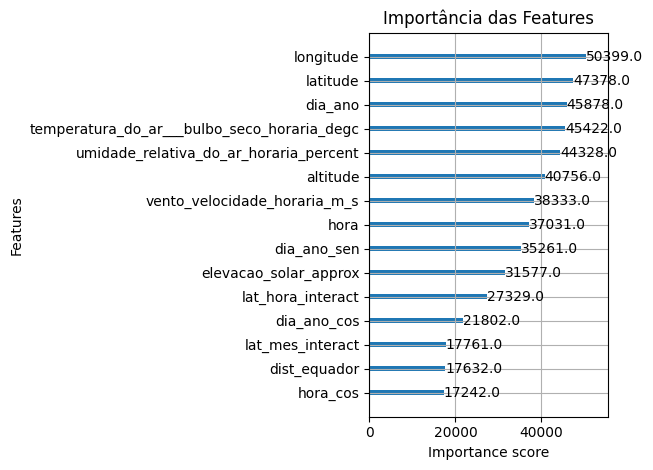

In [78]:
# Plotar a importância das features
plt.figure(figsize=(12, 8))
xgb.plot_importance(modelo, max_num_features=15)
plt.title('Importância das Features')
plt.tight_layout()
plt.show()

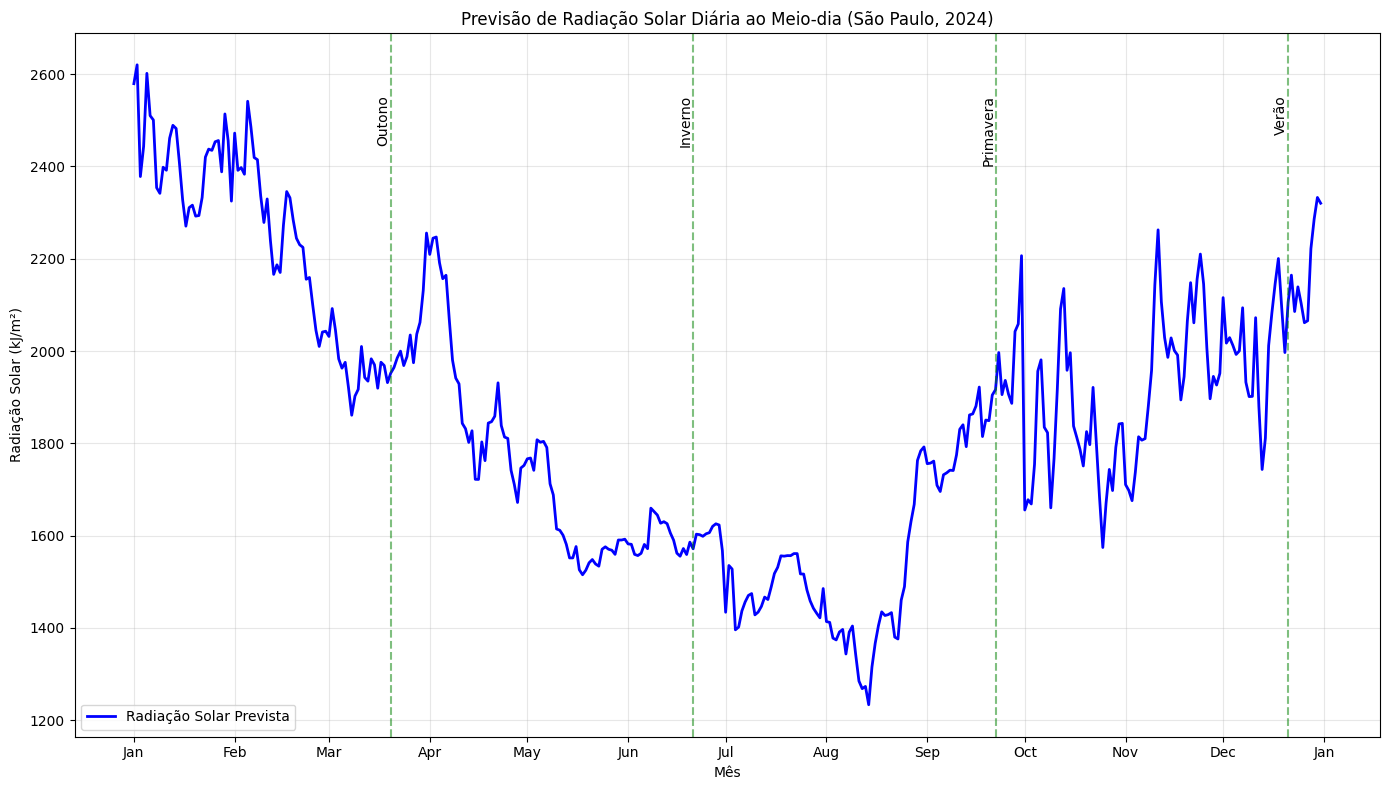

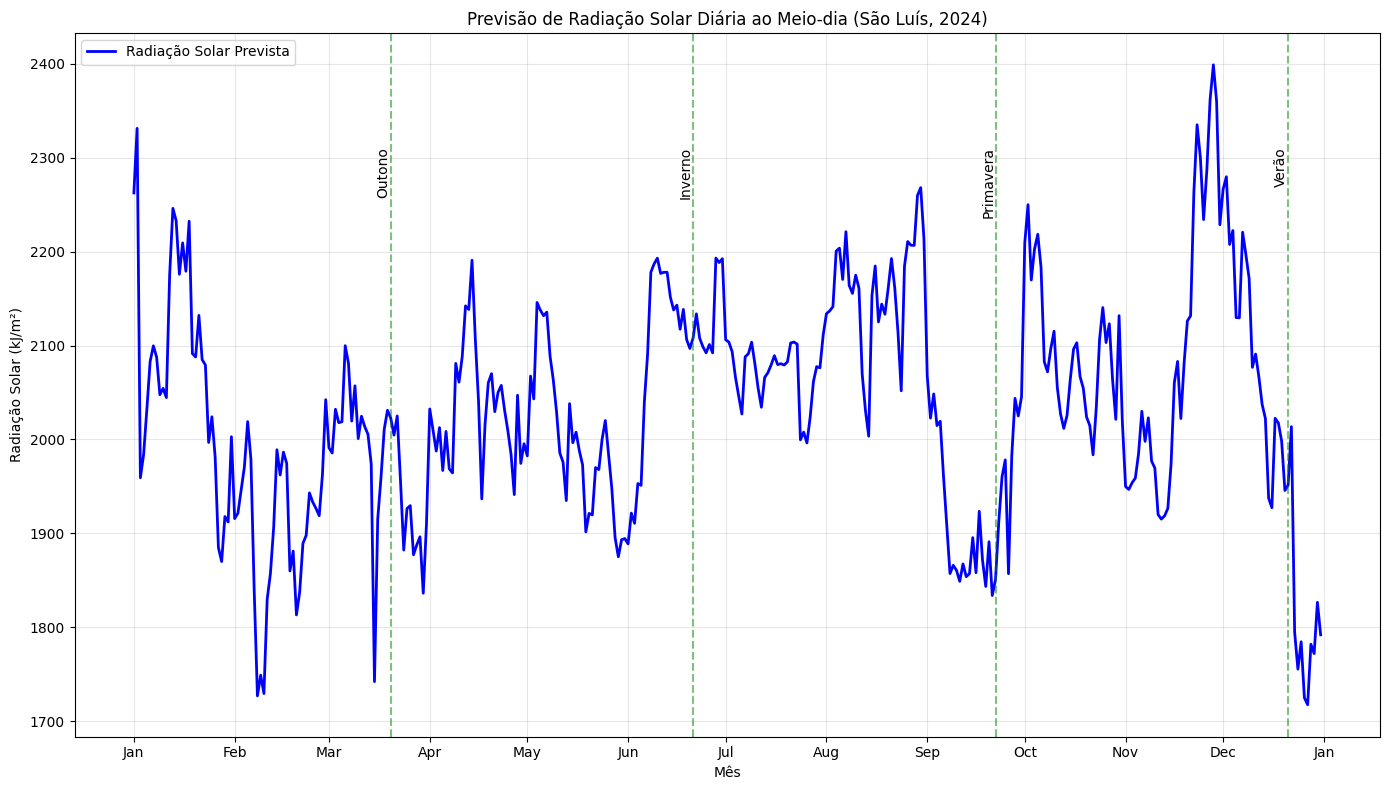

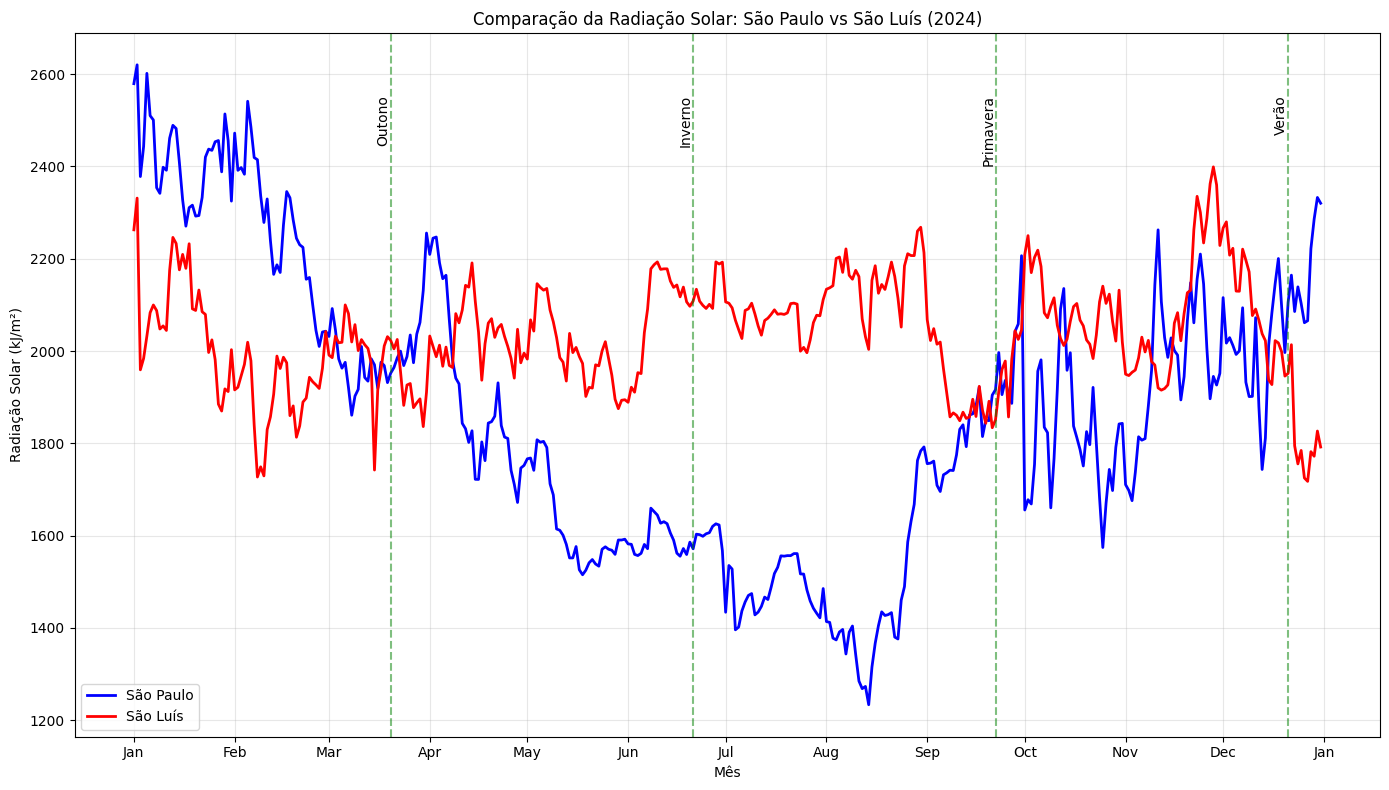

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def previsao_radiacao_anual(modelo, latitude, longitude, altitude=500, ano=2024):
    """
    Gera previsões de radiação solar para um ano inteiro em um local específico
    
    Args:
        modelo: Modelo XGBoost treinado
        latitude: Latitude em graus decimais
        longitude: Longitude em graus decimais
        altitude: Altitude em metros
        ano: Ano para a previsão
        
    Returns:
        DataFrame com previsões diárias
    """
    # Criar datas para o ano inteiro
    data_inicio = datetime(ano, 1, 1)
    data_fim = datetime(ano, 12, 31)
    datas = pd.date_range(data_inicio, data_fim, freq='D')
    
    # Criar DataFrame para armazenar resultados
    resultados = []
    
    # Para cada dia, prever radiação solar ao meio-dia
    for data in datas:
        # Extrair componentes temporais
        mes = data.month
        dia_ano = data.dayofyear
        hora = 12  # Meio-dia
        
        # Criar features cíclicas
        mes_sen = np.sin(2 * np.pi * mes / 12)
        mes_cos = np.cos(2 * np.pi * mes / 12)
        hora_sen = np.sin(2 * np.pi * hora / 24)
        hora_cos = np.cos(2 * np.pi * hora / 24)
        dia_ano_sen = np.sin(2 * np.pi * dia_ano / 365)
        dia_ano_cos = np.cos(2 * np.pi * dia_ano / 365)
        
        # Definir valores meteorológicos médios para o mês
        if mes >= 4 and mes <= 9:  # Meses mais frios no hemisfério sul
            temperatura = 20
            precipitacao = 0
            umidade = 60
        else:  # Meses mais quentes no hemisfério sul
            temperatura = 28
            precipitacao = 5
            umidade = 75
        
        # Criar dados para previsão
        dados = {
            'latitude': [latitude],
            'longitude': [longitude],
            'altitude': [altitude],
            'mes': [mes],
            'dia_ano': [dia_ano],
            'hora': [hora],
            'mes_sen': [mes_sen],
            'mes_cos': [mes_cos],
            'hora_sen': [hora_sen],
            'hora_cos': [hora_cos],
            'dia_ano_sen': [dia_ano_sen],
            'dia_ano_cos': [dia_ano_cos],
            'temperatura_do_ar___bulbo_seco_horaria_degc': [temperatura],
            'precipitacao_total_horario_mm': [precipitacao],
            'umidade_relativa_do_ar_horaria_percent': [umidade],
            'vento_velocidade_horaria_m_s': [3]
        }
        
        # Criar DataFrame
        df_previsao = pd.DataFrame(dados)
        
        # Adicionar features derivadas que o modelo espera
        # Distância do equador (valor absoluto da latitude)
        df_previsao['dist_equador'] = np.abs(latitude)
        
        # Interação latitude-mês (captura variação sazonal por latitude)
        df_previsao['lat_mes_interact'] = latitude * np.cos(2 * np.pi * mes / 12)
        
        # Declinação solar
        df_previsao['declinacao_solar'] = 23.45 * np.sin(2 * np.pi * (dia_ano - 81) / 365)
        
        # Ângulo de elevação solar aproximado
        df_previsao['elevacao_solar_approx'] = 90 - np.abs(latitude - df_previsao['declinacao_solar'])
        
        # Interação latitude-hora
        df_previsao['lat_hora_interact'] = latitude * np.sin(2 * np.pi * (hora - 12) / 24)
        
        # Lista de todas as features que o modelo espera
        features = [
            'latitude', 'longitude', 'altitude',
            'mes', 'dia_ano', 'hora',
            'mes_sen', 'mes_cos', 
            'hora_sen', 'hora_cos',
            'dia_ano_sen', 'dia_ano_cos',
            'temperatura_do_ar___bulbo_seco_horaria_degc',
            'precipitacao_total_horario_mm',
            'umidade_relativa_do_ar_horaria_percent',
            'vento_velocidade_horaria_m_s',
            'dist_equador', 'lat_mes_interact', 'declinacao_solar', 
            'elevacao_solar_approx', 'lat_hora_interact'
        ]
        
        # Filtrar apenas as features que existem
        features_existentes = [f for f in features if f in df_previsao.columns]
        
        # Fazer previsão
        radiacao = modelo.predict(df_previsao[features_existentes])[0]
        
        # Adicionar ao resultado
        resultados.append({
            'data': data,
            'radiacao_prevista': radiacao,
            'mes': mes,
            'dia_ano': dia_ano
        })
    
    # Criar DataFrame com resultados
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

def comparar_radiacao_real_prevista(df_real, df_prevista):
    """
    Compara dados reais e previstos de radiação solar
    
    Args:
        df_real: DataFrame com dados reais
        df_prevista: DataFrame com previsões
        
    Returns:
        DataFrame combinado
    """
    # Garantir que ambos os DataFrames têm coluna de data em formato similar
    if 'data' in df_real.columns and 'data' in df_prevista.columns:
        # Converter para datetime se necessário
        if not pd.api.types.is_datetime64_any_dtype(df_real['data']):
            df_real['data'] = pd.to_datetime(df_real['data'])
        
        # Fazer merge dos DataFrames pela data
        df_combinado = pd.merge(
            df_real[['data', 'radiacao_global_kj_m2']], 
            df_prevista[['data', 'radiacao_prevista']], 
            on='data', 
            how='inner'
        )
        
        return df_combinado
    else:
        return None

def plotar_radiacao_anual(df_resultados, titulo="Previsão de Radiação Solar - Último Ano"):
    """
    Plota a radiação solar ao longo do ano
    
    Args:
        df_resultados: DataFrame com os resultados da previsão
        titulo: Título do gráfico
    """
    plt.figure(figsize=(14, 8))
    
    # Plotar linha de radiação prevista
    plt.plot(df_resultados['data'], df_resultados['radiacao_prevista'], 
             'b-', linewidth=2, label='Radiação Solar Prevista')
    
    # Se houver dados reais, plotar também
    if 'radiacao_global_kj_m2' in df_resultados.columns:
        plt.plot(df_resultados['data'], df_resultados['radiacao_global_kj_m2'], 
                 'r--', linewidth=1.5, alpha=0.7, label='Radiação Solar Real')
    
    # Adicionar linhas verticais para marcar as estações do ano (hemisfério sul)
    estacoes = [
        (datetime(df_resultados['data'].dt.year.iloc[0], 3, 20), 'Outono'),
        (datetime(df_resultados['data'].dt.year.iloc[0], 6, 21), 'Inverno'),
        (datetime(df_resultados['data'].dt.year.iloc[0], 9, 22), 'Primavera'),
        (datetime(df_resultados['data'].dt.year.iloc[0], 12, 21), 'Verão')
    ]
    
    for data, nome in estacoes:
        plt.axvline(x=data, color='green', linestyle='--', alpha=0.5)
        plt.text(data, plt.ylim()[1]*0.95, nome, 
                 rotation=90, verticalalignment='top', horizontalalignment='right')
    
    # Configurar eixo X para mostrar meses
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    # Adicionar rótulos e título
    plt.xlabel('Mês')
    plt.ylabel('Radiação Solar (kJ/m²)')
    plt.title(titulo)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()


# Exemplo de uso com São Paulo e São Luís
# São Paulo, SP
latitude_sp = -23.55
longitude_sp = -46.64
altitude_sp = 760

# São Luís, MA
latitude_sl = -2.53
longitude_sl = -44.30
altitude_sl = 50

# Gerar previsões para as duas cidades
df_previsao_sp = previsao_radiacao_anual(modelo, latitude_sp, longitude_sp, altitude_sp, ano=2024)
df_previsao_sl = previsao_radiacao_anual(modelo, latitude_sl, longitude_sl, altitude_sl, ano=2024)

# Plotar resultados
plotar_radiacao_anual(df_previsao_sp, 
                      titulo=f"Previsão de Radiação Solar Diária ao Meio-dia (São Paulo, 2024)")

plotar_radiacao_anual(df_previsao_sl, 
                      titulo=f"Previsão de Radiação Solar Diária ao Meio-dia (São Luís, 2024)")

# Plotar comparação entre as duas cidades
plt.figure(figsize=(14, 8))
plt.plot(df_previsao_sp['data'], df_previsao_sp['radiacao_prevista'], 
         'b-', linewidth=2, label='São Paulo')
plt.plot(df_previsao_sl['data'], df_previsao_sl['radiacao_prevista'], 
         'r-', linewidth=2, label='São Luís')

# Adicionar linhas verticais para marcar as estações do ano (hemisfério sul)
estacoes = [
    (datetime(2024, 3, 20), 'Outono'),
    (datetime(2024, 6, 21), 'Inverno'),
    (datetime(2024, 9, 22), 'Primavera'),
    (datetime(2024, 12, 21), 'Verão')
]

for data, nome in estacoes:
    plt.axvline(x=data, color='green', linestyle='--', alpha=0.5)
    plt.text(data, plt.ylim()[1]*0.95, nome, 
             rotation=90, verticalalignment='top', horizontalalignment='right')

# Configurar eixo X para mostrar meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adicionar rótulos e título
plt.xlabel('Mês')
plt.ylabel('Radiação Solar (kJ/m²)')
plt.title("Comparação da Radiação Solar: São Paulo vs São Luís (2024)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Salvando o modelo

In [85]:
import pickle
with open('modelo_radiacao_solar.pkl', 'wb') as f:
    pickle.dump(modelo, f)


import pickle
with open('features_info.pkl', 'wb') as f:
    pickle.dump({
        'feature_names': list(X.columns),
        'scaler': scaler
    }, f)

## Considerações Finais

Neste estudo, desenvolvemos um modelo de previsão de radiação solar utilizando dados meteorológicos históricos do INMET.

Principais pontos do trabalho:

1. **Coleta e Preparação de Dados**: Processamos dados meteorológicos de diferentes estações, tratando valores ausentes e normalizando variáveis.

2. **Análise Exploratória**: Identificamos padrões sazonais na radiação solar e correlações com outras variáveis meteorológicas como temperatura e umidade.

3. **Engenharia de Features**: Criamos variáveis cíclicas para representar adequadamente o tempo (hora, dia, mês) e incorporamos informações geográficas.

4. **Modelagem**: Implementamos um modelo de aprendizado de máquina que consegue prever a radiação solar com base em múltiplas variáveis.

5. **Comparação Regional**: Analisamos as diferenças nos padrões de radiação solar entre regiões distintas do Brasil, destacando a influência da latitude.

6. **Limitações**: O modelo atual pode ser aprimorado com dados de mais estações e variáveis adicionais como nebulosidade e aerossóis atmosféricos.

7. **Aplicações Potenciais**: Este modelo pode ser utilizado para dimensionamento de sistemas fotovoltaicos, planejamento agrícola e estudos climáticos.

Próximos passos incluem a implementação de modelos mais complexos como redes neurais e a integração com dados de satélite para melhorar a precisão das previsões.


## 10. Deploy do Modelo e Aplicação Web

O modelo desenvolvido neste estudo foi implementado em produção e está disponível através de:

1. **Aplicação Web**: Uma calculadora de painéis solares que permite dimensionar sistemas fotovoltaicos com base nas previsões do modelo.
   - **URL**: [http://34.44.229.246:8501/](http://34.44.229.246:8501/)

2. **API REST**: Um endpoint que fornece previsões de radiação solar para todas as regiões do Brasil.
   - **URL**: [http://34.44.229.246:8080/model/](http://34.44.229.246:8080/model/)

Sinta-se à vontade para acessar e utilizar estas ferramentas
